In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings

## FIGURE 3A

This example for tuning properties is the Allen V1DD repository: https://github.com/AllenInstitute/allen_v1dd/blob/main/chase/analysis_notebooks/2022-09-12_dg-compare.ipynb

In [24]:
## load in data for a single session and during DGF
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
NWB_DATA_DIR = DATA_DIR / "nwbs"
client =  OPhysClient(DATA_DIR)
nwb_file_paths = list(NWB_DATA_DIR.glob("processed/*.nwb"))  
path = nwb_file_paths[0]

mouse_id = "M409828"
col_vol_id = "13"
plane = 1
session = client.load_ophys_session(f"{mouse_id}_{col_vol_id}")
dg = DriftingGratings(session, plane, trace_type = "dff", dg_type = "full")

In [25]:
## load in data for the first plane in the session
dg_full = []
dg_windowed = []

for plane in session.get_planes()[:1]:
    dg_full.append(DriftingGratings(session, plane, dg_type="full"))
    dg_windowed.append(DriftingGratings(session, plane, dg_type="windowed"))
print(f"Analyzing {len(dg_full)} plane{'s' if len(dg_full) > 1 else ''}")

Analyzing 1 plane


In [26]:
## Look at response metrics for DGF and DGW
reset_metrics = True

if reset_metrics:
    for dgf, dgw in zip(dg_full, dg_windowed):
        dgf._metrics = None
        dgw._metrics = None
        dgf.fit_tuning_curve = False
        dgw.fit_tuning_curve = False

dgf_metrics = StimulusAnalysis.concat_metrics(dg_full)
dgw_metrics = StimulusAnalysis.concat_metrics(dg_windowed)
ss_metrics = DriftingGratings.compute_surround_suppression_metrics(dg_full, dg_windowed)
n_tot = len(dgf_metrics)
dgf_metrics = dgf_metrics[dgf_metrics.is_valid]
dgw_metrics = dgw_metrics[dgw_metrics.is_valid]
ss_metrics = ss_metrics[ss_metrics.is_valid]

dgf_metrics["is_responsive"] = dgf_metrics.is_valid & dgf_metrics.frac_responsive_trials >= 0.5
dgw_metrics["is_responsive"] = dgw_metrics.is_valid & dgw_metrics.frac_responsive_trials >= 0.5

resp_full = dgf_metrics["is_responsive"]
resp_windowed = dgw_metrics["is_responsive"]
n_valid = len(dgf_metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(resp_full, resp_windowed).value_counts()[True]
n_full = resp_full.value_counts()[True]
n_windowed = resp_windowed.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = np.logical_or(resp_full, resp_windowed).value_counts()[True]
n_neither = np.logical_and(~resp_full, ~resp_windowed).value_counts()[True]

print()
print(f"{n_valid}/{n_tot} ({n_valid/n_tot*100:.1f}%) ROIs are valid")
print(f"{n_full}/{n_valid} ({n_full/n_valid*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_valid} ({n_windowed/n_valid*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_valid} ({n_either/n_valid*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_valid} ({n_both/n_valid*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_valid} ({n_full_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_valid} ({n_windowed_only/n_valid*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_valid} ({n_neither/n_valid*100:.1f}%) ROIs are responsive to NEITHER")

Loading DG-full response metrics for session M409828_13, plane 1...
Loading DG-windowed response metrics for session M409828_13, plane 1...

409/1234 (33.1%) ROIs are valid
357/409 (87.3%) ROIs are responsive to DG-full
376/409 (91.9%) ROIs are responsive to DG-windowed

397/409 (97.1%) ROIs are responsive to DG-full OR DG-windowed
336/409 (82.2%) ROIs are responsive to BOTH DG-full AND DG-windowed
21/409 (5.1%) ROIs are responsive to ONLY DG-full
40/409 (9.8%) ROIs are responsive to ONLY DG-windowed
12/409 (2.9%) ROIs are responsive to NEITHER


In [27]:
## function to plot responses for a given ROI
import allen_v1dd.stimulus_analysis.analysis_tools as at
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dgf_metrics, dg_full, dg_windowed, plot=plot, **kwargs)
    print(f"SSI of {index} = {ss_metrics.at[index, 'ssi']:.4f}")

SSI of M409828_13_1_64 = 0.1115


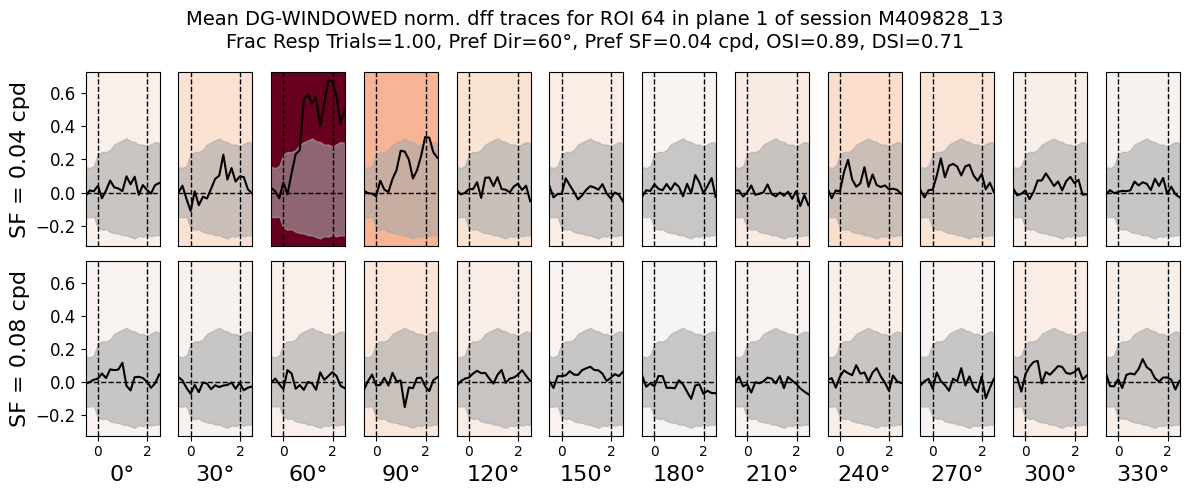

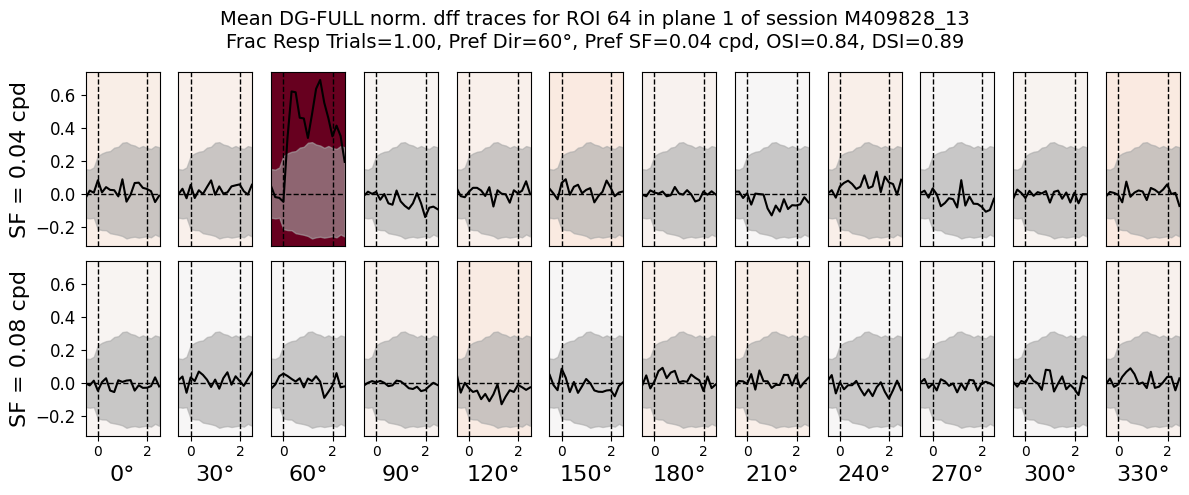

In [28]:
## plot and save figure 3A (condition response dff)
response_plot("M409828_13_1_64", plot="condition_response", trace_type="dff")
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3A_M409828_13_1_64_condition_response_dff.svg"))

## FIGURE 3B

SSI of M409828_13_1_64 = 0.1115


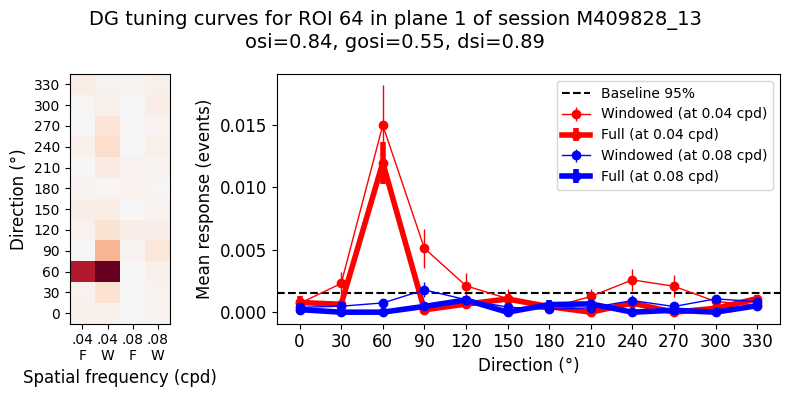

In [29]:
## plot and save figure 3B (heatmap / tuning curve)
response_plot("M409828_13_1_64", plot="tuning")
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3B_PANEL1AND3_M409828_13_1_64_dg_tuning.svg"))

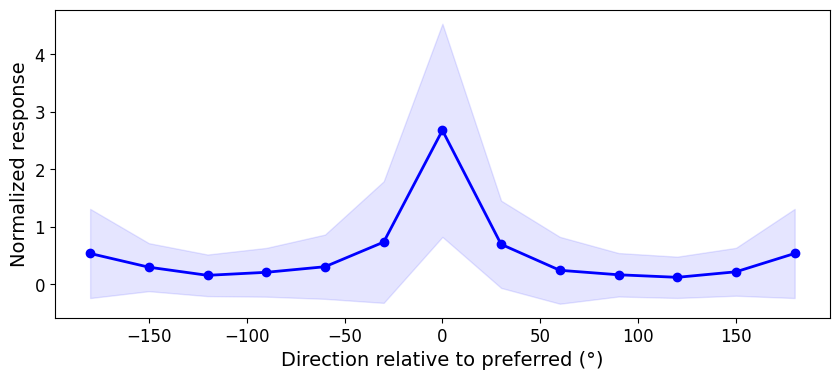

In [30]:
## plot and save figure 3B (panel 2) -- line plot of normalized response of relative preferred direction
dg = dgw
dir_list = dg.dir_list
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6

x = []
y = []
y_ffsi = []

def ratio(a, b):
    if b == 0:
        return 0
    return a/b

for roi in range(dg.n_rois):
    if dg.is_roi_valid[roi] and dg.metrics.frac_responsive_trials[roi] >= 0.5:
        pref_dir_idx = dg.metrics.at[roi, "pref_dir_idx"]
        pref_sf_idx = dg.metrics.at[roi, "pref_sf_idx"]
        null_mean = dg._null_dist_multi_trial[roi].mean()
        null_std = dg._null_dist_multi_trial[roi].std()
        mean_grating_response = np.nanmean(dg.trial_responses[roi])
        mean_blank_response = dg.blank_responses[roi].mean()

        for dir_offset, reldir in zip(relative_dir_idx, relative_dir_list):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            resp = dg.get_mean_response(roi, dir_i, pref_sf_idx)
            norm_resp = (resp - mean_blank_response) / (mean_grating_response + mean_blank_response)

            resp_f = dgf.get_mean_response(roi, dir_i, pref_sf_idx)
            ffsi = ratio(max(resp, resp_f) - resp_f, max(resp, resp_f))

            x.append(reldir)
            y.append(norm_resp)
            y_ffsi.append(ffsi)

# Line plot of means ± error
y_by_dir_idx = [[yy for xx, yy in zip(x, y) if xx == reldir] for reldir in relative_dir_list]
y_means = np.array([np.mean(arr) for arr in y_by_dir_idx])
y_err = np.array([np.std(arr) for arr in y_by_dir_idx])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3B_PANEL2_M409828_13_1_64_dg_tuning.svg"))

## FIGURE 3C

In [31]:
## Load in cell_info dataframe to look at population trends
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [32]:
## Define colors and IDs for each mouse
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

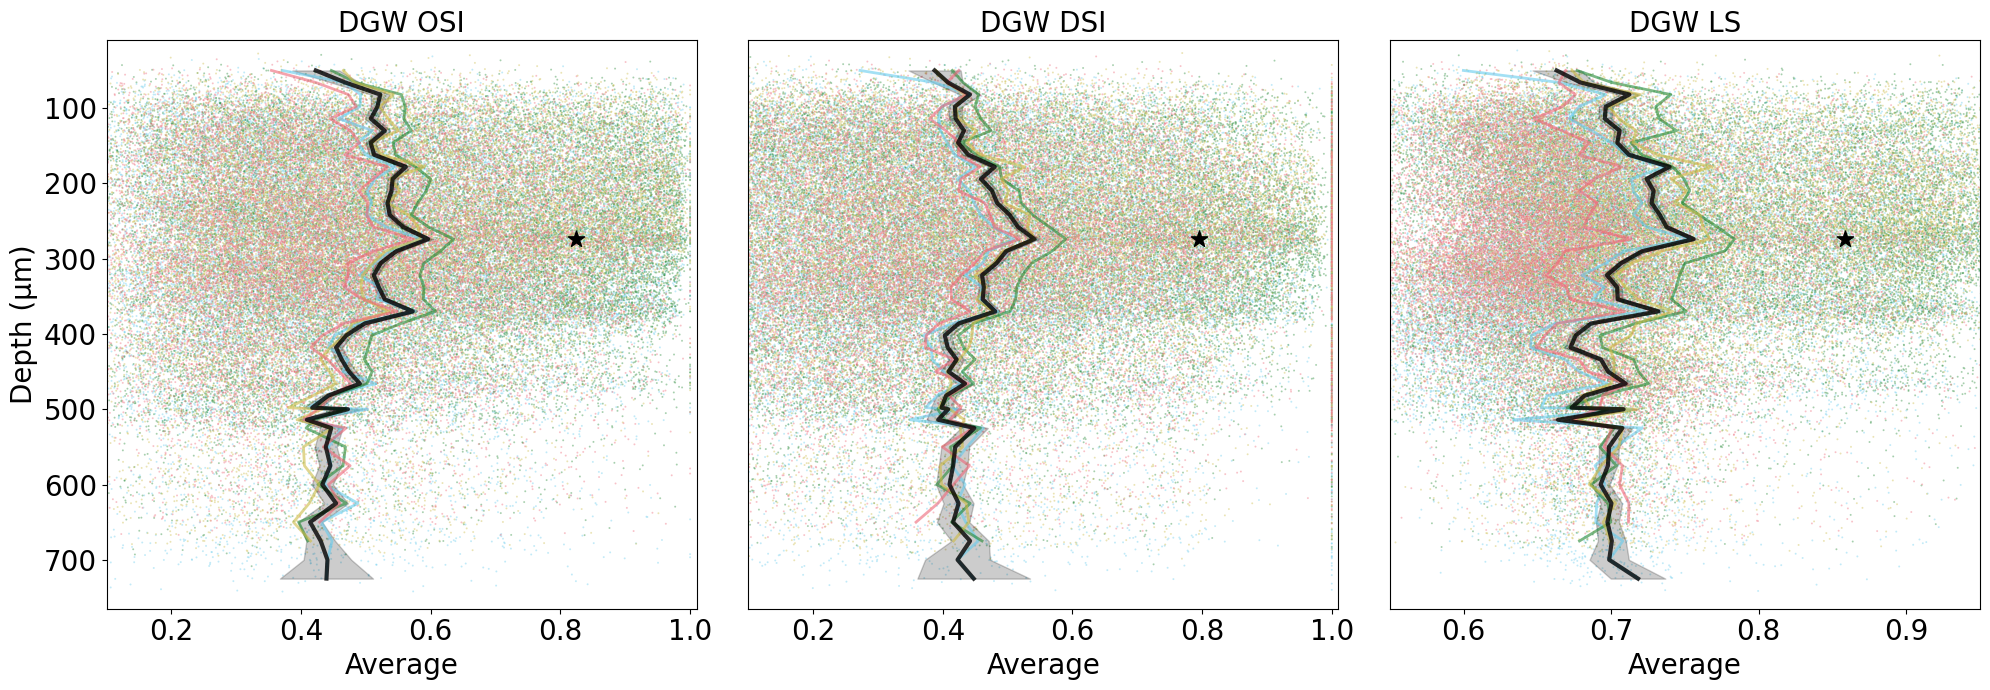

In [33]:
## Plot depth trends for DGW metrics
fontsize = 20
jitter_amount = 10
z_values = cell_info['z'].values

stim_list = ['dgw_osi', 'dgw_dsi', 'dgw_ls']
titles = ['DGW OSI', 'DGW DSI', 'DGW LS']
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

fig, axs = plt.subplots(1, len(stim_list), figsize=(20, 7))
for idx, stim in enumerate(stim_list):
    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z',  
                 hue='mouse_id', 
                 estimator='mean',
                 palette=mouse_colors, 
                 linewidth=2, 
                 errorbar=None, 
                 alpha=0.6, 
                 orient='y', 
                 markers=True,
                 ax=axs[idx],
                 legend=False
                 )
    sns.lineplot(data=cell_info, 
                 x=stim, 
                 y='z', 
                 color='black', 
                 estimator='mean',
                 err_style='band', 
                 errorbar=('se', 2), 
                 n_boot=1000, 
                 linewidth=3, 
                 alpha=0.8, 
                 orient='y', 
                 ax=axs[idx], 
                 legend=False)

    temp_df = cell_info.copy()
    temp_df['z'] = temp_df['z'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    if stim == 'dgf_pref_dir' or stim == 'dgw_pref_dir':
        temp_df[stim] = temp_df[stim] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
                    x=stim,
                    y='z',
                    hue='mouse_id',
                    palette=mouse_colors,
                    s=2,
                    alpha=0.4,
                    ax=axs[idx],
                    legend=False,
                    zorder=0,
    )

    # Put asterisk next to the depth where the max median
    sub_df = cell_info.groupby('z')[stim].mean().reset_index()
    sub_array = sub_df[stim].values
    axs[idx].scatter(sub_array.max() + cell_info[stim].std(), sub_df.iloc[np.where(sub_array == sub_array.max())].z.values[0], 
            color='black', marker='*', s=150, edgecolor='black', zorder=1)

    axs[idx].set_xlabel('Average', fontsize=fontsize)
    axs[idx].set_title(titles[idx], fontsize=fontsize)
    axs[idx].set_ylabel("Depth (µm)", fontsize=fontsize) if idx == 0 else axs[idx].set_ylabel(" ")
    axs[idx].set_yticks([]) if idx != 0 else None
    axs[idx].set_ylim(z_values.min() - 40, z_values.max() + 40)
    axs[idx].set_xlim(0.1, 1.01) if idx < 2 else axs[idx].set_xlim(0.55, 0.95)
    axs[idx].tick_params(axis="both", which="major", labelsize=fontsize)
    axs[idx].invert_yaxis()

plt.tight_layout()
fig.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3C_dgw_depth_plots.png"), format='png', dpi=300)

## FIGURE 3D

In [34]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

In [35]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

In [36]:
## load in decoding results
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

Regression between dgw_osi and DGW decoding accuracy:
  Beta: 0.5929
  R-squared: 0.1057
  t-value: 7.4929
  p-value: 3.318e-13
Regression between dgw_dsi and DGW decoding accuracy:
  Beta: 0.5281
  R-squared: 0.0642
  t-value: 5.7081
  p-value: 2.014e-08
Regression between dgw_ls and DGW decoding accuracy:
  Beta: 0.5270
  R-squared: 0.0317
  t-value: 3.9409
  p-value: 9.338e-05


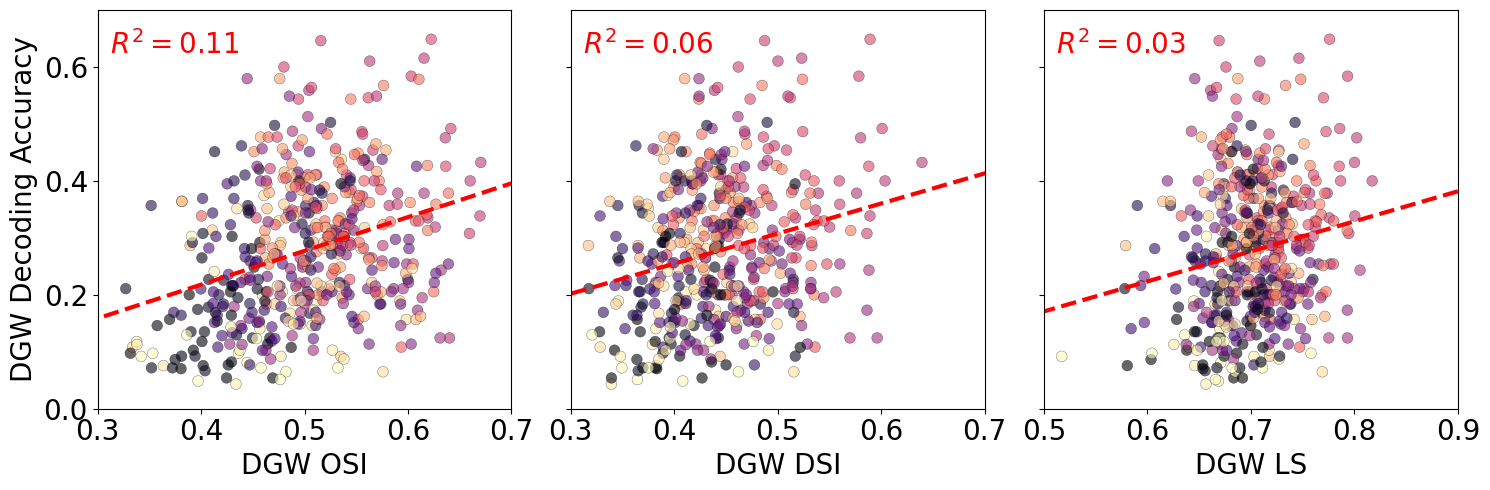

In [37]:
### plot DGW decoding accuracy vs tuning metrics

metrics = ['dgw_osi', 'dgw_dsi', 'dgw_ls']
titles = ['DGW OSI', 'DGW DSI', 'DGW LS']
mouse_mapping = {
    409828: 'slc2',
    416296: 'slc4',
    427836: 'slc5',
    438833: 'teto1'
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for idx, metric in enumerate(metrics):
    ax = axs[idx]
    metric_df = cell_info.groupby(by=['mouse_id', 'column', 'volume', 'z'])[metric].mean().reset_index()
    
    temp_df = all_results_df[(all_results_df['stim_type_testing'] == 'drifting_gratings_windowed') &
                             (all_results_df['depth'] != 500) &
                             (all_results_df['depth'] < 515)].explode('val_accuracy')
    depth_values = temp_df['depth'].unique()
    decoding_df = temp_df.groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth'])['val_accuracy'].mean().reset_index()
    decoding_df = decoding_df.rename(columns={'column_id': 'column', 'volume_id': 'volume', 'depth': 'z'})

    decoding_df['column'] = decoding_df['column'].astype(str)
    decoding_df['volume'] = decoding_df['volume'].astype(str)
    decoding_df['column'] = decoding_df['column'].astype('object')
    decoding_df['mouse_id'] = [mouse_mapping[x] for x in decoding_df['mouse_id']]
    decoding_df['mouse_id'] = decoding_df['mouse_id'].astype('object')

    merge_df = decoding_df.merge(metric_df, on=['mouse_id', 'column', 'volume', 'z'], how='inner', suffixes=('_decoding', '_metric'))

    sns.scatterplot(
        data=merge_df,
        x=metric,
        y='val_accuracy',
        hue='z',
        palette='magma_r',
        s=60,
        alpha=0.6,
        ax=ax, 
        edgecolor='black',
        linewidth=0.3, 
        legend=False,
    )

    smap = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=depth_values.min(), vmax=depth_values.max()))
    smap.set_array([])
    ax.figure.colorbar(smap, ax=ax) if idx == 3 else None

    ax.set_xlim(0.3, 0.7) if idx < 2 else ax.set_xlim(0.5,  0.9)
    ax.set_ylim(0, 0.7)
    ax.xaxis.set_major_locator(plt.LinearLocator(numticks=5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    # Fit a linear regression model
    x_data = merge_df[metric].values
    y_data = merge_df['val_accuracy'].values
    x_data = np.array(x_data, dtype=float).reshape(-1, 1)
    y_data = np.array(y_data, dtype=float)
    x_data = sm.add_constant(x_data)  # Adds a constant term to the predictor
    model = sm.OLS(y_data, x_data).fit()
    
    # Plot the regression line
    x_fit = np.linspace(-1, 1, 100)
    x_fit = sm.add_constant(x_fit)  # Adds a constant term to the predictor
    y_fit = model.predict(x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression')

    # Pull out model results and print
    beta = model.params[1]
    r_squared = model.rsquared
    p_value = model.pvalues[1]
    t_value = model.tvalues[1]

    print(f"Regression between {metric} and DGW decoding accuracy:")
    print(f"  Beta: {beta:.4f}")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  t-value: {t_value:.4f}")
    print(f"  p-value: {p_value:.4g}")

    # Add text annotation for R^2 value
    ax.text(0.03, 0.95, f'$R^2 = {r_squared:.2f}$', 
            transform=ax.transAxes, fontsize=20, verticalalignment='top', color='red')
    ax.set_ylabel('DGW Decoding Accuracy', fontsize=20) #if idx == 0 else ax.set_ylabel('')
    ax.set_xlabel(f'{titles[idx]}', fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "figures", "FIG3D_dgw_decoding_vs_tuning_metrics.png"), format='png', dpi=300)